# Restricted Two Body Problem: Elliptical Orbits Around a Central Mass

This is the general case of a Keperian orbit.<br>
A light body (e.g. a planet) orbits a heavy central body (e.g. the sun).  The orbit is an ellipse with the primary at one focus.<br>
See https://en.wikipedia.org/wiki/Kepler_orbit for a detailed discussion on the theory and history of this problem.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from r2b_data import make_traj_r2b, make_train_r2b, make_datasets_r2b
from r2b_data import make_datasets_earth, make_datasets_solar
from r2b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy

from r2b import KineticEnergy_R2B, PotentialEnergy_R2B, AngularMomentum_R2B
from r2b import Motion_R2B, VectorError, EnergyError
from r2b_model_math import make_position_model_r2b_math, make_physics_model_r2b_math, make_model_r2b_math

In [3]:
# Lightweight serialization
# fname = '../data/r2b/r2b.pickle'
# vartbl = load_vartbl(fname)

### Orbital Elements Refresher

![title](../figs/web/orbital-elements.png)

**Variable Names of Six Keplerian Orbital Elements**
* `a` - semi-major axis; size of the ellipse; mean of periapsis and apoapsis distances
* `e` - eccentricity; shape of the ellipse.  e=0 is a circle, e=1 is a line.  $e^2 = 1 - b^2 / a^2$
* `inc` - inclination; angle between orbital and ecliptic planes
* `Omega` - longitude of the asending node; undefined when inc=0
* `omega` - argument of pericenter; true anomaly where body is closest to the primary.
* `f` - true anomaly; angle of the orbiting body in its orbital plane

**Two Additional Elements**
* `M` - mean anomaly; area swept out by the orbiting body, normalized so a full orbit is $2 \pi$.  Because of the rule of equal area in equal time, a.k.a. conservation of angular momentum, the mean anomly is linear in time
* `N` - mean motion; rate at which mean anomly changes, i.e. $2 \pi / T$ where $T$ is the orbital period

### Generate and Visualize One Example Orbital Path

The module `r2b_data.py` includes functions used to generate training data for the restricted two body problem.<br>
The function `make_traj_r2b` generates a single trajectory for the R2B problem.  It takes as inputs the six traditional orbital elements (`a`, `e`, `inc`, `Omega`, `omega`, `f`).  It creates a new Rebound simulation with two particles: the sun and the orbiting body.  The sun has mass 1.0 in solar mass units, and initial position and velocity 0.  The orbiting body is defined as a "test particle" with a mass of 0, and its initial position and velocity are assigned by Rebound based on the orbital elements.  The orbit is evaluated at intervals of one "day" (1/365 of a year) for a period of `n_years`.  Here I used 2 years, leading to 731 data points counting both the start and end point.  The results are returned in two Dict objects named inputs and outputs.<br>
**Inputs**
* t - vector of times at which the orbit was sampled
* q0 - initial position; 3 vector
* v0 - initial velocity; 3 vector
* mu - the gravitational field strength, $\mu = G \cdot m_0$; constant $\approx 4 \pi^2$ 
when central object has 1.0 solar mass

**Outputs**
* q - orbital positions over time; Nx3 matrix
* v - orbital velocitiy over time; Nx3 matrix
* a - orbital accelaration over time; Nx3 matrix
* q0_rec - recovered initial position; duplicate of q0
* v0_rec - recovered initial velocity; duplicate ov v0
* T - the kinetic energy per unit mass of the test particle; $\frac{1}{2} |v|^2$
* U - the potential energy per unit mass of the test particle; $\frac{-G m_0}{r}$ where $r = |q|$ is the distance
* H - the total energy in the system $H = T + U$
* L - the specific angular momentum, $L = q \times v$


In [4]:
# Generate one example trajectory with an earth-like orbit
a = 1.0
e = 0.0
inc = 0.0
Omega = 0.0
omega = 0.0
f = 0.0
n_years = 2

inputs_traj, outputs_traj = make_traj_r2b(a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, n_years=n_years)

# Combined dict
data_traj = {**inputs_traj, **outputs_traj}

# Review the fields
print('Input fields:', list(inputs_traj.keys()))
print('Output fields:', list(outputs_traj.keys()))

Input fields: ['t', 'q0', 'v0', 'mu']
Output fields: ['q', 'v', 'a', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'L']


In [5]:
# Plot style 
plot_style()

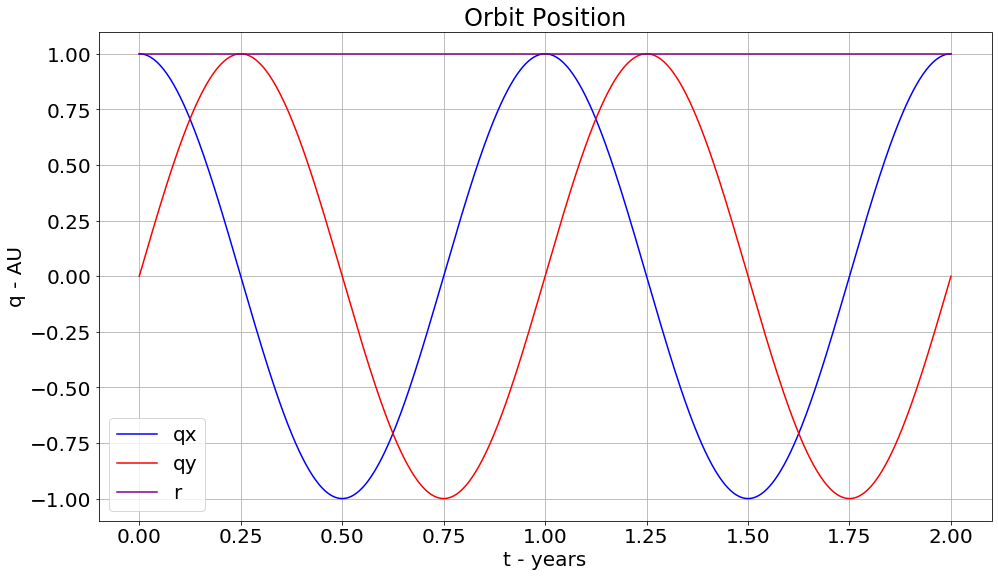

In [6]:
fig, ax = plot_orbit_q(data_traj)

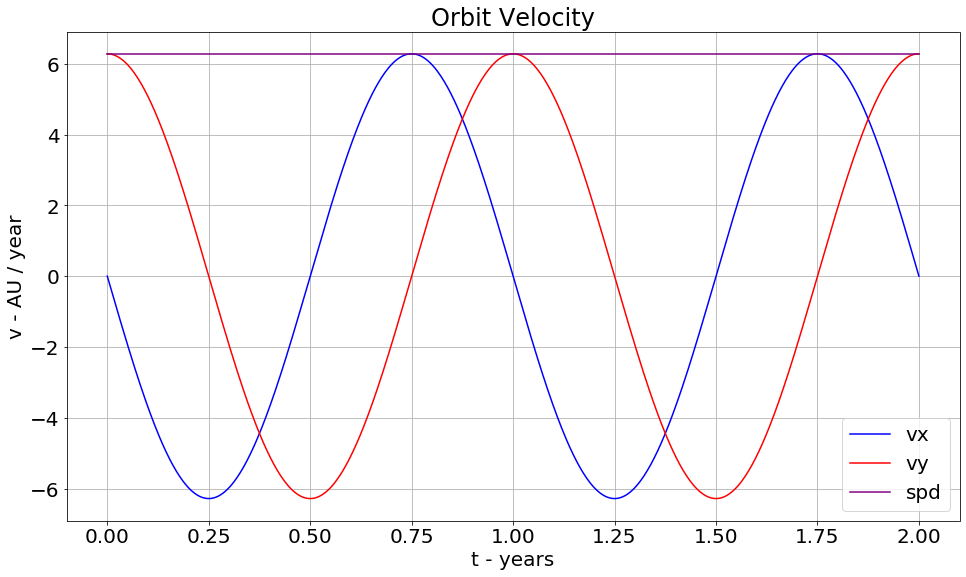

In [7]:
fig, ax = plot_orbit_v(data_traj)

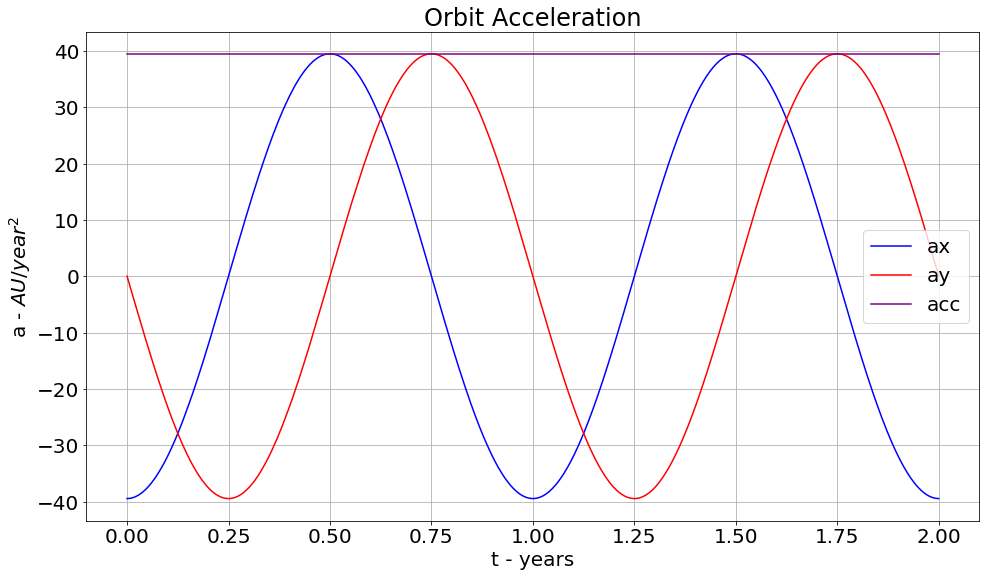

In [8]:
fig, ax = plot_orbit_a(data_traj)

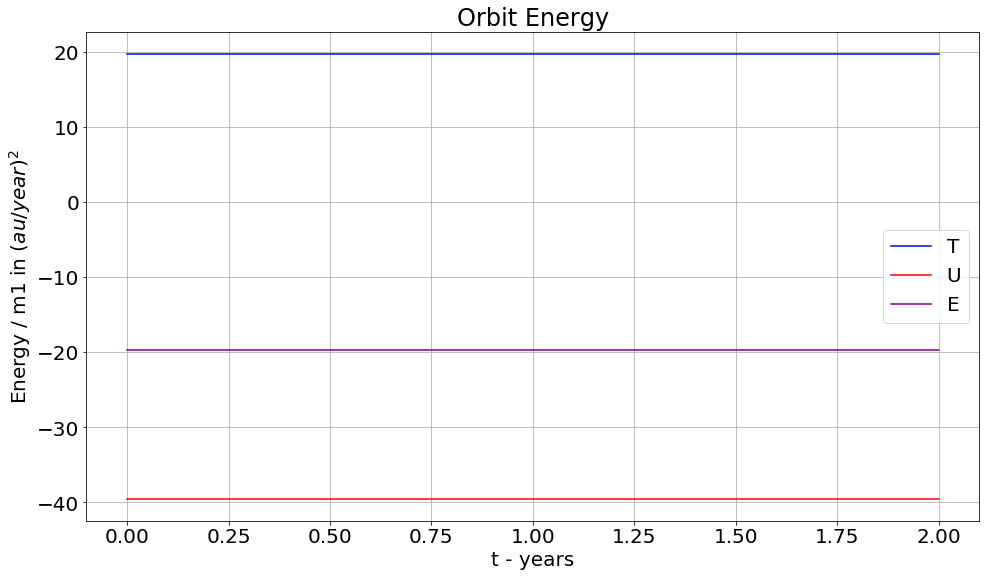

In [9]:
fig, ax = plot_orbit_energy(data_traj)

### Generate Training Data with a Range of Orbital Parameters

The function `make_train_r2b` creates training data for the restricted 2 body problem in the form of dictionaries of numpy arrays.  These are analogous to the outputs of `make_traj_r2b`, but there is an outer index of `n_traj` different trajectories.  The inputs `a_min`, `a_max`, `e_max`, and `inc_max` determine the sampling ranges for the parameters `a`, `e` and `inc` of the orbital elements of the starting configuration.  The other orbital elements (`Omega`, `omega`, `f`) are sampled over the full range of admissible values.<br>
The function `make_datasets_r2b` generates three tensorflow Dataset objects for train, validation and test, respectively.  Data is generated in the form of Numpy arrays using `make_train_r2b` because it is easier to serialize in that format.  The function checks on disk to see if the data is already available, and if so, loads it.  Otherwise it generates and then saves it.  Effective serialization is critical because the data set is expensive to generate.

In [10]:
# Inputs for make_train_r2b
n_traj = 10
n_years = 2
a_min = 0.50
a_max = 32.0
e_max = 0.20
inc_max = np.pi/4.0
seed = 42

In [11]:
# Test make_train_r2b
inputs, outputs= make_train_r2b(n_traj=n_traj, n_years=n_years, a_min=a_min, a_max=a_max, 
                                e_max=e_max, inc_max=inc_max, seed=seed)

In [12]:
# Inputs for make_datasets_r2b
n_traj = 100
vt_split = 0.20
n_years = 2

# The batch size (encapsulated in make_datasets_earth and make_datasets_solar)
batch_size = 64

In [13]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Loaded data from ../data/r2b/2367906283.pickle.


In [14]:
# Create DataSet objects for toy size problem - solar system type orbits
ds_small_trn, ds_small_val, ds_small_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Loaded data from ../data/r2b/1421569704.pickle.


In [15]:
# Create a large data set with 100,000 solar system type orbits
n_traj = 100000

ds_trn, ds_val, ds_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Loaded data from ../data/r2b/2961698777.pickle.


**Generating 140,000 trajectories takes about 110 minutes on my server and uses about 4.6 GB of disk space.**

### Review One Example Batch of Training Data

In [16]:
# Example batch
batch_in, batch_out = list(ds_earth_trn.take(1))[0]
print('Input field names: ', list(batch_in.keys()))
print('Output field names:', list(batch_out.keys()))

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
mu = batch_in['mu']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
L = batch_out['L']

print(f'\nExample batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'mu = {mu.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'L  = {L.shape}')

Input field names:  ['t', 'q0', 'v0', 'mu']
Output field names: ['q', 'v', 'a', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'L']

Example batch sizes:
t  = (64, 731)
q0 = (64, 3)
v0 = (64, 3)
mu = (64,)
q  = (64, 731, 3)
v  = (64, 731, 3)
a  = (64, 731, 3)
H  = (64, 731)
L  = (64, 731, 3)


In [17]:
traj_size = 731

tf.debugging.assert_shapes(
    shapes = {
    # Inputs
    t: (batch_size, traj_size),
    q0: (batch_size, 3),
    v0: (batch_size, 3),
    mu: (batch_size,),
    # Outputs
    q: (batch_size, traj_size, 3),
    v: (batch_size, traj_size, 3),
    a: (batch_size, traj_size, 3),
    q0_rec: (batch_size, 3),
    v0_rec: (batch_size, 3),
    H: (batch_size, traj_size),
    L: (batch_size, traj_size, 3),
    })

### Custom Keras Layers with Physics Computations of Energy and Angular Momentum

The module `r2b.py` contains shared elements used in the restricted 2 body problem.<br>
The layer `KineticEnergy_R2B` computes the kinetic energy (per unit of mass) of the orbiting body given its velocity `v` as a 3-vector.<br>
The kinetetic energy is $T = \frac{1}{2} |v|^2$ <br>
The layer `PotentialEnergy_R2B` computes the potential energy (per unit of mass) of the orbiting body given its position `q` as a 3-vector.  The gravitational field strength `mu` is a constant equating to 1 solar mass.  This could be adjusted to be an input variable, but I've left it constant for simplicity.<br>
The potential energy $U = -\mu / r$ where $r = |q|$.<br>
The layer `AngularMomentum_R2B` computes the specific angular momentum of the orbiting body given its position `q` and velocity `v`.<br>
The angular momentum $L = q \times v$, the 3D vector cross product.  The angular momentum is returned as a 3-vector, NOT as a scalar magnitude.  While technically the restricted two body problem can be solved by a coordinate change in a 2D plane, I wanted an approach that would generalize well to the three body problem.

In addition to the custom layers computing the physical quantities, there are also custom loss functions intended to be used with them.<br>
The custom loss function `VectorError` returns the relative error 
$$E = \frac{|y_{true} - y_{pred}|}{|y_{true}| + R}$$
where $R$ is an optional regularization term that defaults to 0.<br>
The custom loss function `EnergyError` returns a log scaled squared error
$$E = \log{\left[1 + \left(\frac{y_{pred} - y_{true}}{y_{true}}\right)^2\right]}$$
The log scaling is introduced so that the error doesn't blow up catastrophically when distance gets too small.  This was causing problems in training when an un-scaled energy error was used.

**Call layers with physics computations**

In [18]:
T = KineticEnergy_R2B()(v)
T.shape

TensorShape([64, 731])

In [19]:
U = PotentialEnergy_R2B()(q)
U.shape

TensorShape([64, 731])

In [20]:
L = AngularMomentum_R2B()([q, v])
L.shape

TensorShape([64, 731, 3])

## Conversion of initial configuration to orbital elements

In [21]:
qx = q0[:,0]
qy = q0[:,1]
qz = q0[:,2]
vx = v0[:,0]
vy = v0[:,1]
vz = v0[:,2]
inputs_cart = (qx, qy, qz, vx, vy, vz, mu)

In [22]:
elts = ConfigToOrbitalElement()(inputs_cart)
a0, e0, inc0, Omega0, omega0, f0, M0, N0 = elts

In [23]:
# Review shapes
print(f'Example batch sizes:')
print(f'qx   = {qx.shape}')
print(f'vx   = {vx.shape}')
print(f'mu   = {mu.shape}')
print(f'a0   = {a0.shape}')

Example batch sizes:
qx   = (64,)
vx   = (64,)
mu   = (64,)
a0   = (64,)


In [24]:
# Display the numerical value of the graviational field strength mu in the (years, AU, solar masses) unit system
mu_reb = inputs['mu'][0]
print(f'mu = {mu_reb:20.12f}')

mu =      39.476924896240


### Mathematical Model - Predict Orbits Analytically Using Orbital Elements

A **position model** predicts the Cartesian position (qx, qy, qz) of the system as a function of a time.  It takes as inputs (t, q0, v0).  It also outputs velocities (vx, vy, vz) that are consistent with the orbital elements.  These will be exactly correct if the model is correct, i.e. if the 5 orbital elements other than `f` are constant, and if `f` is evolving consistently with the mean motion and Kepler's equation.<br>
A position model can be used to build a **motion model** which also outputs the (exact) velocity and acceleration based on the position as a function of time.  This is done using automatic differentiation.<br>
A motion model can in turn be used to create a **physics model**.  In addition to the position, velocity, and acceleration, this model also computes the physical quantities energy $H$ and angular momentum $L$.<br>
The idea of this design is to abstract the common steps of passing from a position model to a physics model so they do not need to be duplicated over different position models.  The module `r2b.py` includes a class `Motion_R2B` that implements this design.  The constructor accepts a position model as described above.  The `call` method of this model 

The module `r2b_model_math` includes 

In [25]:
position_model_math = make_position_model_r2b_math(traj_size=traj_size)

In [26]:
qx, qy, qz, vx, vy, vz = position_model_math([t, q0, v0, mu])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')
print(f'qz = {qz.shape}')

qx = (64, 731, 1)
qy = (64, 731, 1)
qz = (64, 731, 1)


In [27]:
# keras.utils.plot_model(position_model_math, '../figs/model_plots/r2b/position_model_math.png')

In [28]:
# position_model_math.summary()

**Motion Model: Compute v and a from q using automatic differentiation**<br>
Factory function that accepts any position model<br>
Instantiated here from mathematical position model

In [29]:
motion_model_math = Motion_R2B(position_model=position_model_math, name='motion_model')

In [30]:
q, v, a = motion_model_math([t, q0, v0, mu])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 3)
v: (64, 731, 3)
a: (64, 731, 3)


In [31]:
motion_model_math.summary()

Model: "motion_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_r2b_math (Model)       ((None, 731, 1), (None, 7 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


**Full physics model: computes energy and angular momentum from q, v**<br>
Factory function that accepts any position model.<br>
Instantiated here from mathematical position model.

In [32]:
model_math = make_model_r2b_math()

In [33]:
model_math.summary()

Model: "model_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t (InputLayer)                  [(None, 731)]        0                                            
__________________________________________________________________________________________________
q0 (InputLayer)                 [(None, 3)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 3)]          0                                            
__________________________________________________________________________________________________
mu (InputLayer)                 [(None, 1)]          0                                            
_________________________________________________________________________________________

## Review outputs of math model

In [35]:
q, v, a, q0_rec, v0_rec, H, L  = model_math([t, q0, v0, mu])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'L = {L.shape}')

model output shapes:
q = (64, 731, 3)
v = (64, 731, 3)
a = (64, 731, 3)
q0_rec = (64, 3)
v0_rec = (64, 3)
H = (64, 731)
L = (64, 731, 3)


In [36]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H'),
        'L': VectorError(name='L'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0}

In [37]:
# Compile the mathematical model on a single GPU
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [38]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_earth_trn)

2/2 [==============================] - 25s 12s/step - loss: 7.9098e-05 - q_loss: 5.4735e-08 - v_loss: 5.5175e-08 - a_loss: 7.8720e-05 - q0_rec_loss: 5.3879e-08 - v0_rec_loss: 2.0933e-07 - H_loss: 1.7598e-09 - L_loss: 2.3955e-09


[7.90976506266361e-05,
 5.4734763e-08,
 5.517528e-08,
 7.872037e-05,
 5.387892e-08,
 2.0933446e-07,
 1.7597953e-09,
 2.395481e-09]

In [39]:
# Evaluate the math model on the solar-system -like data set
model_math.evaluate(ds_val)

313/313 [==============================] - 18s 57ms/step - loss: 3.7548e-06 - q_loss: 8.0964e-08 - v_loss: 9.2683e-08 - a_loss: 1.3002e-07 - q0_rec_loss: 8.0956e-08 - v0_rec_loss: 3.2926e-06 - H_loss: 6.5865e-08 - L_loss: 1.1736e-08


[3.7547867544073894e-06,
 8.096397e-08,
 9.268257e-08,
 1.3001626e-07,
 8.095561e-08,
 3.2925664e-06,
 6.586483e-08,
 1.17358e-08]

In [ ]:
def make_datasets_solar(n_traj=1000, vt_split=0.20, n_years=2, batch_size=64, seed=42):
    """Make 3 data sets for solar-system -like orbits with a range of a, e, and inclinations."""
    # Set the parameters for earth-like orbits
    a_min = 0.50
    a_max = 32.0
    e_max = 0.20
    inc_max = np.pi / 4.0
    
    # Delegate to make_datasets_r2bc
    return make_datasets_r2b(n_traj=n_traj, vt_split=vt_split, n_years=n_years, a_min=a_min, a_max=a_max, 
                             e_max=e_max, inc_max=inc_max, seed=seed, batch_size=batch_size)

In [ ]:
ds_trn, ds_val, ds_tst = make_datasets_solar(n_traj=100000)